# Implementation of a counterfeit detection algorithm

My mission here for the french organization <i>ONCFM (National Anti-Counterfeiting Organization)</i> is to set up an algorithm that will automatically identify counterfeit euro banknotes based on their dimensions and elements that compose them.<br>
<br>
 
<strong>SUMMARY</strong> :

    
 <strong>Tools </strong>[(here)](#another_cell_0)
 
  <strong>I. Exploratory data analysis</strong><br>
     -- A. Dataset description [(here)](#another_cell_a)<br>
     -- B. Treatment of missing values using linear regression to predict them<br>
     ---- <i>a. Linear regression (statsmodel) [(here)](#another_cell_b)</i><br>
     ---- <i>b. Results analysis [(here)](#another_cell_c)</i><br>
     <i>------ → Calculation of levers</i><br>
     <i>------ → Calculation of studentized residuals</i><br>
     <i>------ → Cook's Distance calculation</i><br>
     <i>------ → Testing the collinearity of variables</i><br>
     <i>------ → Testing homoscedasticity</i><br>
     <i>------ → Testing residual normality</i><br>
     ---- <i>c. Prediction and imputation of missing values [(here)](#another_cell_d)</i>    
     -- C. Principal component analysis (PCA) on features<br>
     ---- <i>a. Data standardization [(here)](#another_cell_e)</i><br>
     ---- <i>b. Explained Variance Ratio and Scree plot [(here)](#another_cell_f)</i><br>
     ---- <i>c. Correlation circles and projections of points [(here)](#another_cell_g)</i><br>
     -- D. Univariate analysis on target [(here)](#another_cell_h)<br>
  <strong>II. K-means clustering</strong><br>
     -- A. Finding the optimal number of clusters for classification (Elbow method) [(here)](#another_cell_i)</i><br>
     -- B. K-means model [(here)](#another_cell_j)<br> 
     -- C. Factorial plane [(here)](#another_cell_k)  
     -- D. Centroid analysis [(here)](#another_cell_l)<br>
     -- E. ... <br>
  <strong>III. Logistic regression</strong><br>
  <strong>IV. Comparison of the two models and implementation of the function</strong><br>




<a id='another_cell_0'></a>

### Tools

In [1]:
!pip install yellowbrick

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import researchpy
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import t
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [3]:
def shapiro_test(x):
    '''
    The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

    Parameters :
        x (array_like) : array of sample data

    Returns :
        statistic (float) : the test statistic
        p-value (float) : the p-value for the hypothesis test
    '''
    from scipy.stats import shapiro
    x1, pval1 = shapiro(x)

    print("="*100,"\n")
    print("Shapiro-Wilk test","\n")
    if pval1 < 0.05:
        print("pval1 < 0.05 ==> the null hypothesis is rejected (the variable does not follow a normal law)")
    else:
        print("pval1 > 0.05 ==> We cannot reject the null hypothesis H0 (the variable follows a normal law)")
    print()
    print("="*100,"\n")
    
def display_scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    Parameters: 
        pca : the result of instantian of PCA in scikit learn
    '''
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Principal components")
    plt.ylabel("Variance Explained (%)")
    plt.title("Explained Variance Per Principal Component")
    plt.show(block=False)
    
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''
    Display correlation circles, one for each factorial plane
    
    Parameters :
        pcs : model_pca.components
        n_comp (float) : the number of components
        pca : the result of instantiate of PCA in scikit learn
        axis_rank (float) : the rank of the axis to visualize
        labels : labels of our variables    
    '''
    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialize the matplotlib figure
            #fig, ax = plt.subplots(figsize=(8,8))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Correlation Circle (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''
    Display a scatter plot on a factorial plane, one for each factorial plane

    Parameters :
        X_projected : model_pca.transform(X_scaled)
        n_comp (float) : the number of components
        pca : the result of instantiate of PCA in scikit learn
        axis_rank : the rank of the axis to visualize
        labels : labels of our variables
    '''
    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialize the matplotlib figure      
            #fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            #plt.show(block=False)
            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))

## I. Exploratory data analysis

<a id='another_cell_a'></a>

### A. Dataset description

In [4]:
data = pd.read_csv('billets.csv', sep=";", decimal='.')
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [5]:
data.shape

(1500, 7)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


<div class="alert-success">
    <u>Notice</u> :
<i><br><li> We have a dataset containing the geometric measurements of 1 500 banknotes :<br>
    → 1 000 are true and 500 are false</br></li>
<li> One variable is boolean : it give us the nature of the banknote (True or False), we can replace the values by 0 et 1</li>
</i></div>
<div class="alert-danger">
    <u>Danger</u> :
<i><br><li>37 variables are missing in the "margin_low" column<br>
    → We can predict missing values on "margin low" variable using linear regression (statsmodel)
</i></div>

In [7]:
data['is_genuine'].replace([True, False],[1,0], inplace=True)

### B. Treatment of missing values using linear regression to predict them

<a id='another_cell_b'></a>

#### a. Linear regression (statsmodel)

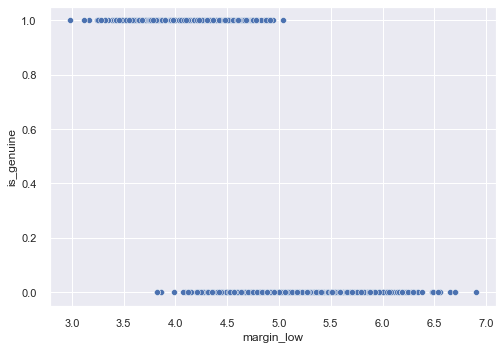

In [8]:
# Graphical representation
sns.set()
ax = sns.scatterplot(x="margin_low", y="is_genuine", data=data)

<div class="alert-success">
    <u>Notice</u> :
<i><br><li>Beyond a margin low of 5, we notice that the banknotes are mostly fake<br>
</i></div>

<div class="alert-warning">
    <u>Warning</u> :
<i><br><li>We decide to remove the "is_genuine" variable to avoid data leakage (or an untimely influence of this variable on our results)<br>
</i></div>

In [9]:
# Data preparation
df = data[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']]

In [10]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 21 Sep 2022   Prob (F-statistic):          2.60e-202
Time:                        10:53:12   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

<div class="alert-success">
    <u>Notice</u> :
<i><br><li>We see here that all parameters are significant and have a p-value less than 5%, the expected test level
<i><br><li>The 𝑅2 is about 0.47 as is the adjusted 𝑅2
</i></div>

<a id='another_cell_c'></a>

#### b. Results analysis

In [11]:
# We will perform the tests at a level 𝛼 = 5%
alpha = 0.05

# Number of individuals
n = df['margin_low'].count()

# Number of variables
p = 6

analysis = pd.DataFrame({'obs':np.arange(1, n+1)})

- <u>Calculation of levers (atypicality of explanatory variables)</u> :

We consider that the threshold of the levers is : $2∗\frac{p}{n}$

In [12]:
analysis['levers'] = reg_multi.get_influence().hat_matrix_diag
threshold_levers = 2*p/n

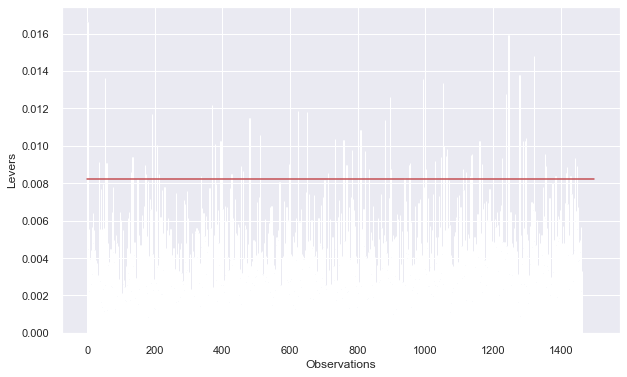

In [13]:
plt.figure(figsize=(10,6))
plt.bar(analysis['obs'], analysis['levers'])
plt.xticks(np.arange(0, 1500, step=200))
plt.xlabel('Observations')
plt.ylabel('Levers')
plt.plot([0, 1500], [threshold_levers, threshold_levers], color='r')
plt.show()

In [14]:
# Selection of the points for which the lever is upper than the threshold
lev_obs = analysis.loc[analysis['levers'] > threshold_levers, :]
print(lev_obs.head(),"\n")
print(len(lev_obs),"are upper than the threshold")

    obs    levers
0     1  0.016606
2     3  0.008298
34   35  0.009156
52   53  0.013635
56   57  0.009087 

75 are upper than the threshold


- <u>Calculation of studentized residuals (atypicality of the variable to be explained)</u> :

Here we have $n−p−1 > 30$,<br>
so the threshold for the studentized residuals approximately follows a Student law $T(n−p−1)$

In [15]:
analysis['rstudent'] = reg_multi.get_influence().resid_studentized_internal
rstudent_threshold = t.ppf(1-alpha/2,n-p-1)

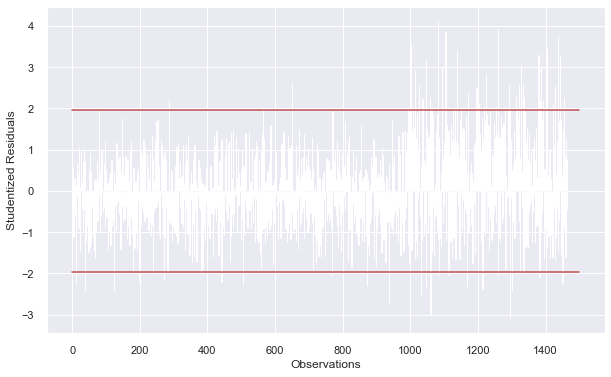

In [16]:
plt.figure(figsize=(10,6))
plt.bar(analysis["obs"], analysis["rstudent"])
plt.xticks(np.arange(0, 1500, step=200))
plt.xlabel("Observations")
plt.ylabel("Studentized Residuals")
plt.plot([0, 1500], [rstudent_threshold, rstudent_threshold], color='r')
plt.plot([0, 1500], [-rstudent_threshold, -rstudent_threshold], color='r')
plt.show()

In [17]:
rstu_obs = analysis.loc[(analysis['rstudent'] > rstudent_threshold) & (analysis['rstudent'] > -rstudent_threshold)]
print(rstu_obs.head(),"\n")
print(len(rstu_obs),"are upper than thresholds")

     obs    levers  rstudent
285  286  0.007106  2.198945
564  565  0.004796  1.979045
649  650  0.011824  2.623086
993  994  0.013583  1.996766
998  999  0.005801  2.892652 

53 are upper than thresholds


- <u>Cook's Distance calculation</u> :

In [18]:
influence = reg_multi.get_influence().summary_frame()

The threshold of Cook's distance is *n-p*.

In [19]:
analysis['dcooks'] = influence['cooks_d']
dcook_threshold = 3/(n-p)

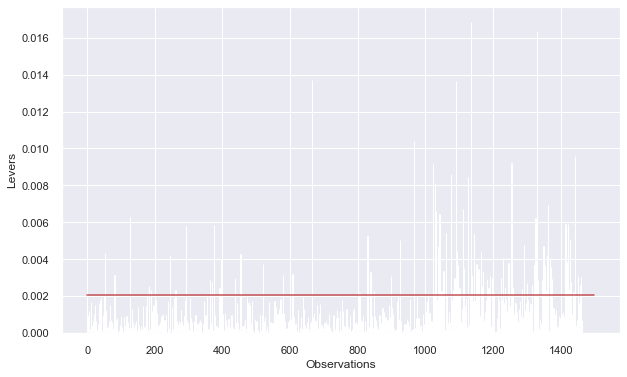

In [20]:
# Detection of influential observations
plt.figure(figsize=(10,6))
plt.bar(analysis['obs'], analysis['dcooks'])
plt.xticks(np.arange(0, 1500, step=200))
plt.xlabel('Observations')
plt.ylabel('Levers')
plt.plot([0, 1500], [dcook_threshold, dcook_threshold], color='r')
plt.show()

In [21]:
dcooks_obs = analysis.loc[(analysis['dcooks'] > dcook_threshold)]
print(dcooks_obs.head(),"\n")
print(len(dcooks_obs),"are upper than thresholds")

     obs    levers  rstudent    dcooks
52    53  0.013635 -1.372229  0.004338
80    81  0.003806  0.022997  0.003151
125  126  0.001589  0.172284  0.006308
176  177  0.002004 -0.622183  0.002176
182  183  0.002507  0.174186  0.002560 

118 are upper than thresholds


- <u>Testing the collinearity of variables</u> :

In [22]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686333,
 1.138260573608249,
 1.230114515556036,
 1.4044037781843624,
 1.576950145366581]

<div class="alert-success">
    <u>Notice</u> :
<i><br><li>All the coefficients are less than 10, so there is no collinearity problem
</i></div>

- <u>Testing homoscedasticity</u> :

In [23]:
# Test the constancy of the variance of the residuals
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval,"\n")

if pval < 5/100:
    print("pvalue < 5% ,  H0 is rejected: the variances are heteroscedastic (not constant)")
else : print("pvalue > 5%, H0 cannot be rejected: the variances are constant (or homoscedastic)")

p value test Breusch Pagan: 7.7595352162174e-16 

pvalue < 5% ,  H0 is rejected: the variances are heteroscedastic (not constant)


- <u>Testing residual normality</u> :

In [24]:
shapiro_test(reg_multi.resid)


Shapiro-Wilk test 

pval1 < 0.05 ==> the null hypothesis is rejected (the variable does not follow a normal law)




<div class="alert-warning">
    <u>Warning</u> :
<i><br><li>The hypothesis of the linear model are not respected : the residuals are neither Gaussian nor homoscedastic
</i></div>    
<div class="alert-success">
<i><li>But given the size of our sample (1500 individuals), the results of the model will still be viable
</i></div>

<a id='another_cell_d'></a>

#### c. Prediction and imputation of missing values

In [25]:
# Prediction
df_na = df[df["margin_low"].isnull()]
predict_na = reg_multi.predict(df_na)

In [26]:
# Imputations
data["margin_low"][data["margin_low"].isnull()] = predict_na
df["margin_low"][df["margin_low"].isnull()] = predict_na

<ipython-input-26-0750ac3ef90a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["margin_low"][data["margin_low"].isnull()] = predict_na
C:\Users\hp\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [27]:
# Final check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


### C. Principal component analysis (PCA) on features

<a id='another_cell_e'></a> 

#### a. Data standardization

In [28]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Check
pd.DataFrame(X_scaled, columns=df.columns).describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1500.00,1500.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.01,-2.97,-3.38,-2.28,-3.80,-3.65
25%,-0.68,-0.70,-0.65,-0.70,-0.70,-0.74
50%,0.01,0.03,-0.00,-0.26,-0.05,0.32
75%,0.69,0.67,0.71,0.59,0.68,0.76
max,3.45,2.84,3.16,3.66,3.27,2.02


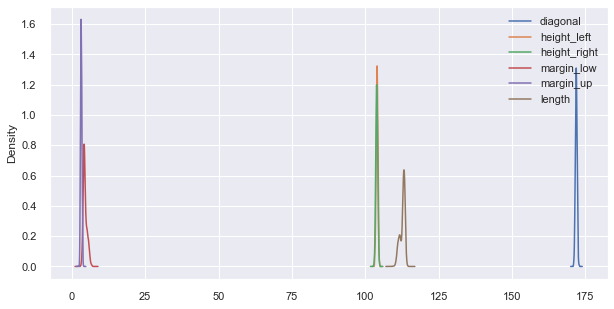

In [29]:
# Before standardisation
X1 = pd.DataFrame(df,columns=df.columns)
X1.plot(kind='density',sharex=True,figsize=(10,5),layout=(10,1))
plt.show()

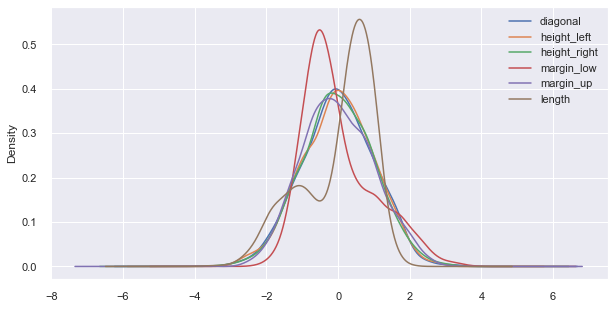

In [30]:
# After standardisation
pd.DataFrame(X_scaled,columns=df.columns).plot(kind='density',sharex=True,figsize=(10,5),layout=(10,1))
plt.show()

In [31]:
pd.DataFrame(X_scaled, index=df.index,columns=df.columns).head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.055390,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.081987,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.126591,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.309463,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.672532,1.417677,-0.158750


<a id='another_cell_f'></a> 

#### b. Explained Variance Ratio and Scree plot

In [32]:
# Create the PCA model
model_pca = PCA()

# Fit the model with the data
X_reduced = model_pca.fit_transform(X_scaled)

In [33]:
# Explained variance ratio
model_pca.explained_variance_ratio_.round(2)

array([0.43, 0.17, 0.13, 0.12, 0.1 , 0.05])

In [34]:
# Explained variance ratio cumsum
model_pca.explained_variance_ratio_.cumsum().round(2)

array([0.43, 0.6 , 0.73, 0.85, 0.95, 1.  ])

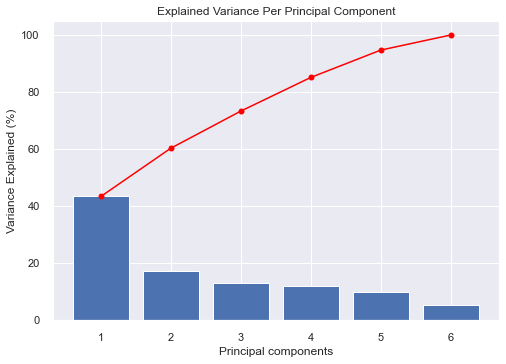

In [35]:
# Scree plot
display_scree_plot(model_pca)

<div class="alert-success">
    <u>Notice</u> :
<i><br><li>We recover 60% inertia from the 2nd component
</i></div>

In [36]:
# Number of components to study
num_components = 2
pcs = model_pca.components_ 
pc1 = model_pca.components_[0]
pc2 = model_pca.components_[1]

In [37]:
df.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [38]:
pc1

array([-0.08469767,  0.33063448,  0.39355544,  0.50769282,  0.4394146 ,
       -0.52705225])

In [39]:
pc2

array([ 0.94130387,  0.30752844,  0.10833184, -0.07243963, -0.00495445,
        0.04863598])

<a id='another_cell_g'></a> 

#### c. Correlation circles and projections of points

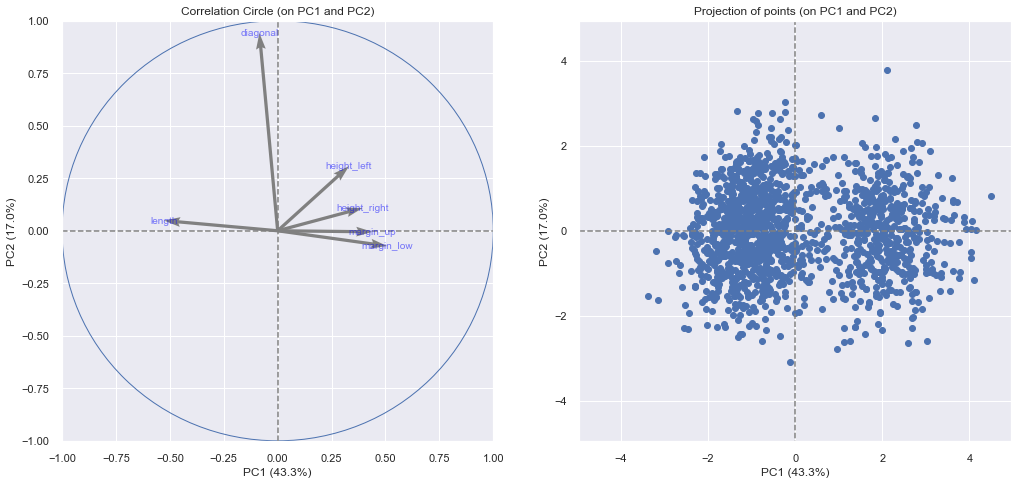

In [40]:
X_projected = model_pca.transform(X_scaled)

plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(0,1)], labels = np.array(df.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(0,1)])
plt.show()

<div class="alert-success">
    <u>Axes interpretation</u> :
<i><br><li><strong> pc1</strong> → mainly represented by the variables "heigh" (left and right) and "margin" (high and low)</br></li>
<li><strong> pc2</strong> → mainly represented by the variables "diagonal" and "heigh" (left and right)</li>
</i></div>

<a id='another_cell_h'></a> 

### D. Univariate analysis on target

In [41]:
target = data[['is_genuine']]

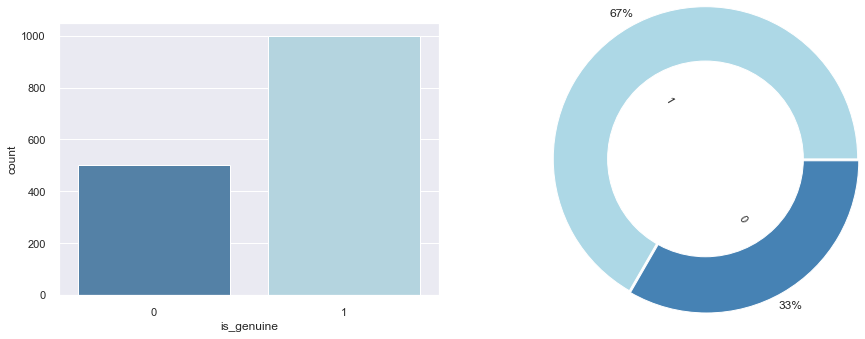

In [42]:
palette =["steelblue","lightblue",]
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x="is_genuine", data=data, palette = palette)
plt.subplot(122)
data["is_genuine"].value_counts().plot(kind="pie", ylabel='', autopct='%1.0f%%', radius=1.4, explode = (0, 0.02), 
                                       colors=["lightblue","steelblue"], pctdistance=1.1, labeldistance=0.4, rotatelabels=True)
circle = plt.Circle( (0,0), 0.9, color='white')
p = plt.gcf()
p.gca().add_artist(circle)

plt.show()

In [43]:
data_arch = data.groupby(by="is_genuine").mean().round(2)
data_arch

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
0,171.90,104.19,104.14,5.21,3.35,111.63
1,171.99,103.95,103.81,4.12,3.05,113.20


<div class="alert-success">
    <u>Archetype of the false banknote</u> :<br>
<i><li><strong> diagonal</strong> → 171.90 mm</li>
<li><strong> height_left</strong> → 104.19 mm</li>
<li><strong> height_right</strong> → 104.14 mm</li>
<li><strong> margin_low</strong> → 5.21 mm</li>
<li><strong> margin_up</strong> → 3.35 mm</li>
<li><strong> length</strong> → 111.63 mm</li>
</i></div><br>
<div class="alert-success">
    <u>Archetype of the true banknote</u> :<br>
<i><li><strong> diagonal</strong> → 171.99 mm</li>
<li><strong> height_left</strong> → 103.95 mm</li>
<li><strong> height_right</strong> → 103.81 mm</li>
<li><strong> margin_low</strong> → 4.12 mm</li>
<li><strong> margin_up</strong> → 3.05 mm</li>
<li><strong> length</strong> → 113.20 mm</li>
</i></div><br>
<div class="alert-success">
    <strong>→ In general, real banknotes will have a higher <i>length</i> while the <i>height_left</i>, <i>height_right</i>, <i>margin_low</i> and <i>margin_up</i> variables will be higher for counterfeit banknotes</strong>
</i></div>

## II. K-means clustering

<a id='another_cell_i'></a> 

### A. Finding the optimal number of clusters for classification (Elbow method)

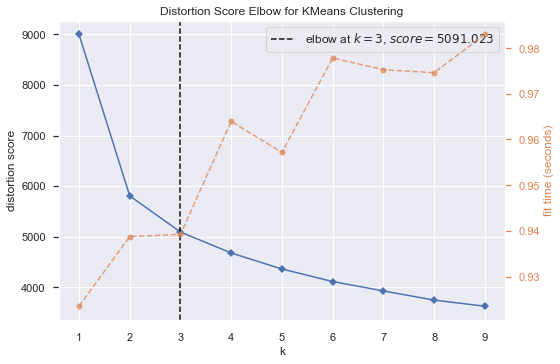

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
model = KElbowVisualizer(KMeans(), k=(1,10))
model.fit(X_scaled)
model.show()

<div class="alert-success">
    <u>Notice</u> :
<i><br><li>According to the elbow curve and silhouette score, the optimal number of clusters is 3</br></li>
</i></div>

<a id='another_cell_j'></a> 

### B. K-means model

In [61]:
# K-Means model with 3 clusters
model_kmeans = KMeans(n_clusters=2)
model_kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to
clusters =  model_kmeans.fit_predict(X_scaled)

# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=df.index,columns=df.columns)
X_clustered["cluster"] = clusters

X_clustered.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,-0.486540,2.774123,3.163240,0.055390,-1.128325,0.173651,0
1,-1.633729,-2.236535,-0.799668,-1.081987,-0.696799,0.471666,1
2,2.397823,1.504756,-1.291191,-0.126591,-0.912562,0.551901,1
3,-1.961498,-0.399294,0.060498,-1.309463,-0.610494,0.953075,1
4,-0.748754,0.836669,-1.414072,-0.672532,1.417677,-0.158750,1


<a id='another_cell_k'></a> 

### C. Factorial plane

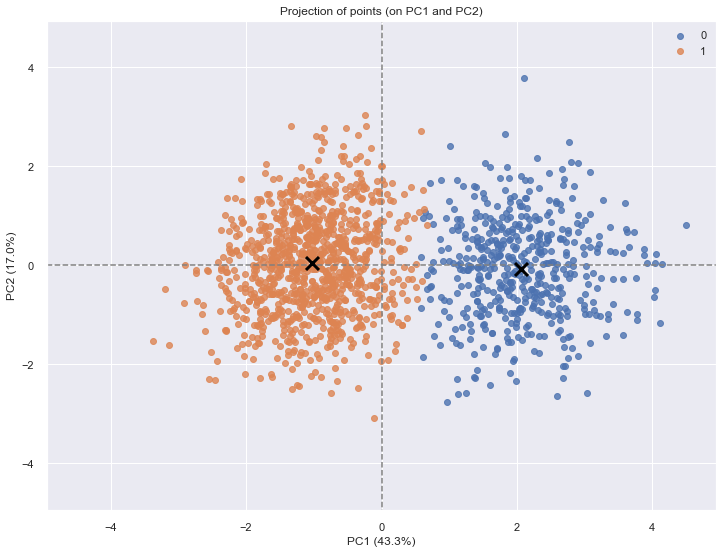

In [62]:
centres_reduced = model_pca.transform(model_kmeans.cluster_centers_)
plt.figure(figsize=(12,9))
display_factorial_planes(X_reduced, 2, model_pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)
plt.show()

<a id='another_cell_l'></a> 

### D. Centroid analysis

In [63]:
kmeans_ =  X_clustered.groupby(by="cluster").mean()
display(kmeans_)

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster,,,,,,
0,-0.194323,0.570713,0.713365,1.118257,0.864176,-1.200833
1,0.096000,-0.281946,-0.352419,-0.552445,-0.426924,0.593240


<div class="alert-success">
    <u>Clusters interpretation</u> :
<i><li><strong> Cluster 0</strong> → ...</li>
<li><strong> Cluster 1</strong> → ...</li>
</i></div>